Pixeltests School Data Science

*Unit 2, Sprint 2, Module 3*

---
<p style="padding: 10px; border: 2px solid red;">
    <b>Before you start:</b> Today is the day you should submit the dataset for your Unit 2 Build Week project. You can review the guidelines and make your submission in the Build Week course for your cohort on Canvas.</p>

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/pixeltests/datasets/main/' #You might not need this, use the data from Kaggle directly!
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Hyperparameter Tuning

This sprint, the module projects will focus on creating and improving a model for the Tanazania Water Pump dataset. Your goal is to create a model to predict whether a water pump is functional, non-functional, or needs repair.

Dataset source: [DrivenData.org](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/).

## Directions

- **Task 0:** Enter the [Kaggle](https://www.kaggle.com/t/6169ee7701164d24943c98eda2de9b5e) competition using exactly this link!
The tasks for this project are as follows:

- **Task 1:** Use `wrangle` function to import training and test data.
- **Task 2:** Split training data into feature matrix `X` and target vector `y`.
- **Task 3:** Establish the baseline accuracy score for your dataset.
- **Task 4:** Build `clf_dt`.
- **Task 5:** Build `clf_rf`.
- **Task 6:** Evaluate classifiers using k-fold cross-validation.
- **Task 7:** Tune hyperparameters for best performing classifier.
- **Task 8:** Print out best score and params for model.
- **Task 9:** Create `submission.csv` and upload to Kaggle.

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `pandas-profiling`
- `sklearn`

# I. Wrangle Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.concat([pd.read_csv(fm_path,
                                  na_values=[0, -2.000000e-08]),
                      pd.read_csv(tv_path)],axis=1)
        df.drop('id',inplace=True,axis=1)
    else:
        df = pd.read_csv(fm_path,
                         na_values=[0, -2.000000e-08],
                         index_col='id')

    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)

    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    # Drop duplicate columns
    dupe_cols = [col for col in df.head(15).T.duplicated().index
                 if df.head(15).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True)

    return df

In [18]:
fm_path = '/content/drive/MyDrive/Tanzania_Data_Set/train_features.csv'
tv_path = '/content/drive/MyDrive/Tanzania_Data_Set/train_labels.csv'
test_path = '/content/drive/MyDrive/Tanzania_Data_Set/test_features.csv'

**Task 1:** Using the above `wrangle` function to read `train_features.csv` and `train_labels.csv` into the DataFrame `df`, and `test_features.csv` into the DataFrame `X_test`.

In [19]:
import pandas as pd
df = wrangle(fm_path,tv_path)

In [20]:
X_test = wrangle(test_path)

# II. Split Data

**Task 2:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'status_group'`.

**Note:** You won't need to do a train-test split because you'll use cross-validation instead.

In [21]:
X = df.drop('status_group',axis=1)
y = df['status_group']

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_val = train_test_split(X,train_size=0.80,random_state=41)
y_train, y_val = train_test_split(y,train_size=0.80,random_state=41)

# III. Establish Baseline

**Task 3:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents.

In [10]:
baseline_acc = y.value_counts(normalize=True)[0]
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5430765993265994


# IV. Build Models

**Task 4:** Build a `Pipeline` named `clf_dt`. Your `Pipeline` should include:

- an `OrdinalEncoder` transformer for categorical features.
- a `SimpleImputer` transformer fot missing values.
- a `DecisionTreeClassifier` Predictor.

**Note:** Do not train `clf_dt`. You'll do that in a subsequent task.

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
from sklearn.tree import DecisionTreeClassifier
clf_dt = make_pipeline(ce.OrdinalEncoder(),SimpleImputer(strategy='median'),StandardScaler(),DecisionTreeClassifier(random_state=41,max_depth=15))

**Task 5:** Build a `Pipeline` named `clf_rf`. Your `Pipeline` should include:

- an `OrdinalEncoder` transformer for categorical features.
- a `SimpleImputer` transformer fot missing values.
- a `RandomForestClassifier` predictor.

**Note:** Do not train `clf_rf`. You'll do that in a subsequent task.

In [38]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = make_pipeline(ce.OrdinalEncoder(),SimpleImputer(strategy='median'),StandardScaler(),
                       RandomForestClassifier(max_features=10,n_estimators=40,n_jobs=-1,random_state=41))

# V. Check Metrics

**Task 6:** Evaluate the performance of both of your classifiers using k-fold cross-validation.

In [39]:
from sklearn.model_selection import cross_val_score

cv_scores_dt = cross_val_score(clf_dt,X_train,y_train,cv=3,scoring='accuracy')


cv_scores_rf = cross_val_score(clf_rf,X_train,y_train,cv=3,scoring='accuracy')

In [43]:
clf_rf.fit(X_train,y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoin...
dtype: int64},
                                         {'col': 'waterpoint_type_group',
                                          'data_type': dtype('O'),
                                          'mapping': communal standpipe    1
improved spring       2
hand pump             3
other                 4
cattle trough         5
dam                   6
NaN                  -2
dtype: int64}])),
                ('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_features=10, n_estimators=40,
                                        n_jobs=-1, random_state=41))])

In [25]:
print('CV scores DecisionTreeClassifier')
print(cv_scores_dt)
print('Mean CV accuracy score:', cv_scores_dt.mean())
print('STD CV accuracy score:', cv_scores_dt.std())

CV scores DecisionTreeClassifier
[0.74636995 0.75607639 0.74621212]
Mean CV accuracy score: 0.7495528198653197
STD CV accuracy score: 0.004613309877999147


In [40]:
print('CV score RandomForestClassifier')
print(cv_scores_rf)
print('Mean CV accuracy score:', cv_scores_rf.mean())
print('STD CV accuracy score:', cv_scores_rf.std())

CV score RandomForestClassifier
[0.78653725 0.7890625  0.78282828]
Mean CV accuracy score: 0.7861426767676768
STD CV accuracy score: 0.0025603555050281446


# VI. Tune Model

**Task 7:** Choose the best performing of your two models and tune its hyperparameters using a `RandomizedSearchCV` named `model`. Make sure that you include cross-validation and that `n_iter` is set to at least `25`.

**Note:** If you're not sure which hyperparameters to tune, check the notes from today's guided project and the `sklearn` documentation.

In [35]:
from sklearn.model_selection import RandomizedSearchCV
param_distributions = {'randomforestclassifier__n_estimators':[20,30,40],'randomforestclassifier__max_features':[10,15,20]}
model = RandomizedSearchCV(clf_rf,param_distributions=param_distributions,n_iter=25,cv=3,scoring='accuracy',n_jobs=-1)

In [36]:
model.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=25. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('simpleimputer',
                                              SimpleImputer(strategy='median')),
                                             ('standardscaler',
                                              StandardScaler()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier())]),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_features': [10,
                                                                                 15,
                                                                                 20],
                                        'randomforestclassifier__n_estimators': [20,
                                                                                 30,
                                                                                 40]},
                   scoring='accuracy')

**Task 8:** Print out the best score and best params for `model`.

In [37]:
best_score = model.best_score_
best_params = model.best_params_

print('Best score for `model`:', best_score)
print('Best params for `model`:', best_params)

Best score for `model`: 0.7866687710437711
Best params for `model`: {'randomforestclassifier__n_estimators': 40, 'randomforestclassifier__max_features': 10}


In [44]:
y_pred = clf_rf.predict(X_test)

# Communicate Results

**Task 9:** Create a DataFrame `submission` whose index is the same as `X_test` and that has one column `'status_group'` with your predictions. Next, save this DataFrame as a CSV file and upload your submissions to our competition site.

**Note:** Check the `sample_submission.csv` file on the competition website to make sure your submissions follows the same formatting.

In [48]:

sample_submission = pd.read_csv("/content/drive/MyDrive/Tanzania_Data_Set/tanzania sample solution.csv")
submission = pd.DataFrame({'S.No.':sample_submission['S.No.']})
submission['status_group'] = y_pred
legends = {'functional' : '0', 'functional needs repair' : '1', 'non functional' : '2'}
submission['status_group'] = submission['status_group'].map(legends)
submission.to_csv('/content/drive/MyDrive/Tanzania_Data_Set/submissionRF2.csv')

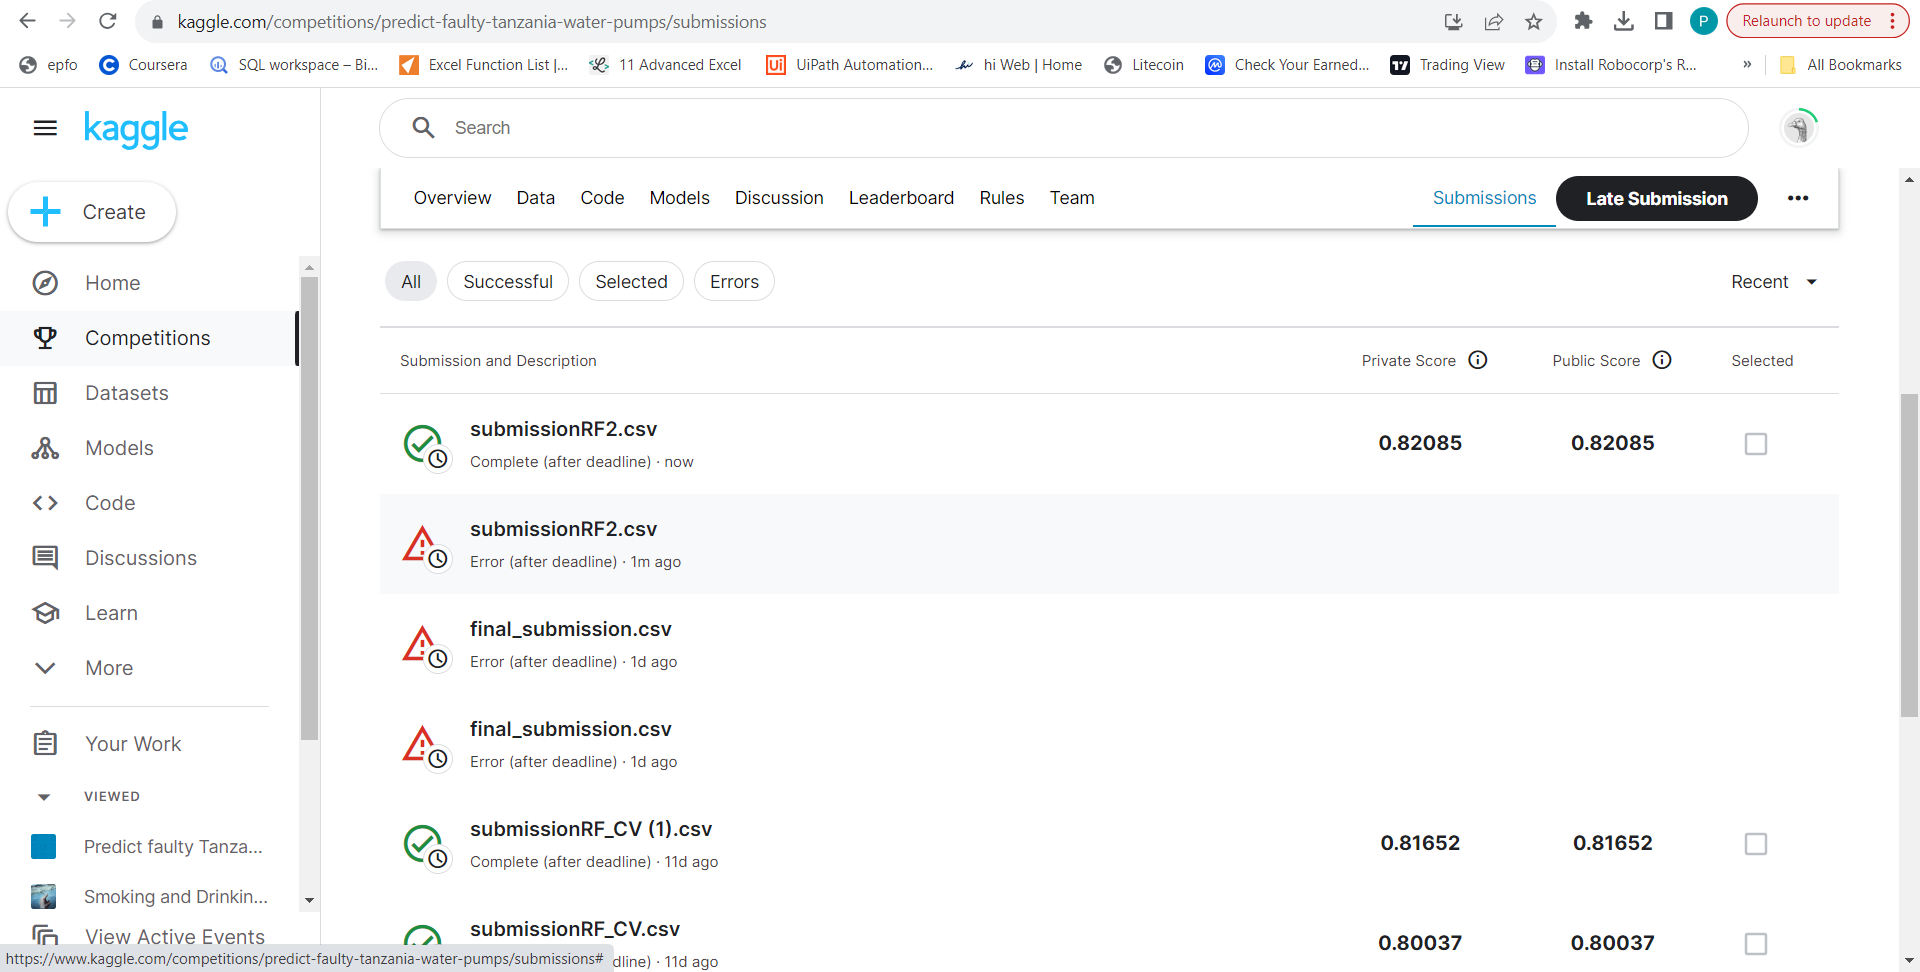

In [52]:
from IPython.display import Image
Image(filename='/content/drive/MyDrive/Tanzania_Data_Set/Kaggle_submissionRFCV2.png')